In [1]:
#import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import dask.dataframe as dd
from IPython.display import display, HTML
import pandas as pd
import cudf

In [2]:
df = pd.read_parquet('train_test/imputed_train.parquet')

In [3]:
activation = df['activation'].value_counts()

In [4]:
print(activation)

activation
0    12159962
1       70016
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import joblib
# Assuming df is your DataFrame

# Define features and target
target_column = 'activation'
features = [col for col in df.columns if col not in (target_column, 'ind_recommended')]
categorical_features = ['merchant_profile_01']
numerical_features = [col for col in features if col not in categorical_features]

# Separate features and target
X = df[features]
y = df[target_column]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Define preprocessing for numerical columns (scaling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns (one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train_transformed = preprocessor.fit_transform(X_train_resampled)
preprocessor_save_path = 'scaler_model/preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_save_path)

X_test_transformed = preprocessor.transform(X_test)


In [11]:
dtrain = xgb.DMatrix(X_train_transformed, label=y_train_resampled)
dtest = xgb.DMatrix(X_test_transformed, label=y_test)

# XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'device': 'cuda',
    'tree_method': 'hist', 
    'eval_metric': ['logloss', 'auc'],
}

# Train the model
num_boost_round = 100
bst = xgb.train(params, dtrain, num_boost_round, [(dtest, 'test'), (dtrain, 'train')], early_stopping_rounds=10)

# Make predictions
y_pred = bst.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)  # Thresholding for binary classification

# Evaluation
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

/home/FYP/poon0064/.conda/envs/RunJupyter/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	test-logloss:0.56179	test-auc:0.90268	train-logloss:0.55867	train-auc:0.90774
[1]	test-logloss:0.48872	test-auc:0.91309	train-logloss:0.48165	train-auc:0.91837
[2]	test-logloss:0.44553	test-auc:0.91567	train-logloss:0.43481	train-auc:0.92149
[3]	test-logloss:0.41705	test-auc:0.91812	train-logloss:0.40301	train-auc:0.92420
[4]	test-logloss:0.39864	test-auc:0.91961	train-logloss:0.38171	train-auc:0.92583
[5]	test-logloss:0.38585	test-auc:0.92128	train-logloss:0.36634	train-auc:0.92789
[6]	test-logloss:0.37734	test-auc:0.92241	train-logloss:0.35546	train-auc:0.92926
[7]	test-logloss:0.37092	test-auc:0.92346	train-logloss:0.34682	train-auc:0.93079
[8]	test-logloss:0.36610	test-auc:0.92429	train-logloss:0.34048	train-auc:0.93196
[9]	test-logloss:0.36293	test-auc:0.92504	train-logloss:0.33572	train-auc:0.93308
[10]	test-logloss:0.35987	test-auc:0.92579	train-logloss:0.33113	train-auc:0.93424
[11]	test-logloss:0.35823	test-auc:0.92629	train-logloss:0.32779	train-auc:0.93518
[12]	test-logl

In [14]:
test_df = pd.read_parquet('train_test/imputed_test.parquet')
original_test_df = pd.read_csv('evaluation.csv')

In [16]:
customer_merchant_info = original_test_df[['customer', 'merchant']]


In [17]:
import joblib

preprocessor = joblib.load('scaler_model/preprocessor.joblib')
X_new_transformed = preprocessor.transform(test_df[features])
dtest_new = xgb.DMatrix(X_new_transformed)
pred_probs = bst.predict(dtest_new)

In [18]:
predictions = pd.DataFrame({
    'predicted_score': pred_probs
})

# Concatenate the Customer and Merchant columns with the predictions
# Make sure that the indices align correctly
final_output = pd.concat([customer_merchant_info.reset_index(drop=True), predictions], axis=1)

In [19]:
final_output.to_csv('submission/final_submission.csv', index=False)

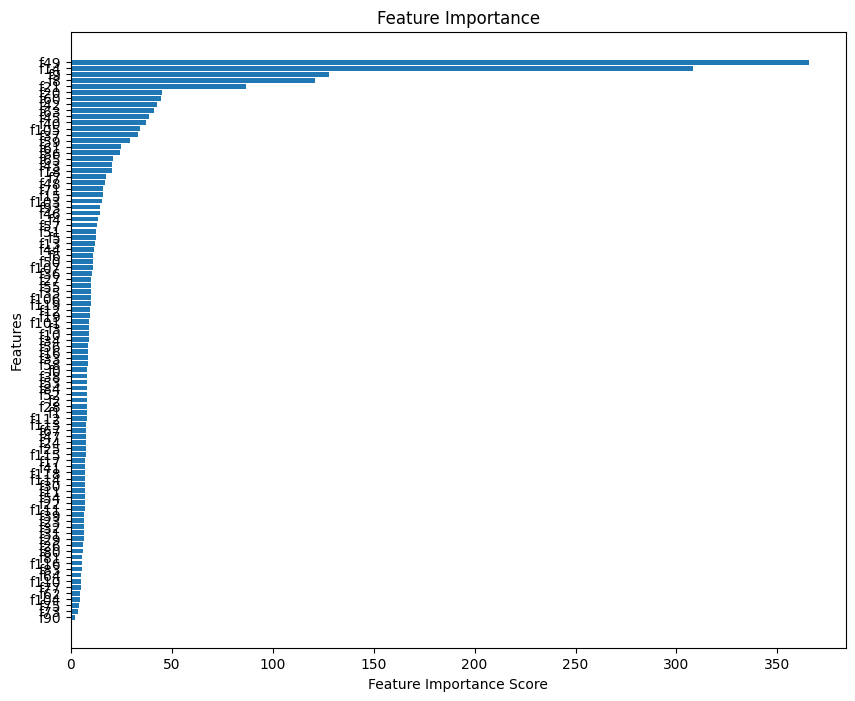

In [21]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming bst is your trained model
# Get feature importance
feature_importance = bst.get_score(importance_type='gain')

# Sort feature importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and scores
f_names = [i[0] for i in sorted_importance]
f_scores = [i[1] for i in sorted_importance]

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.barh(f_names, f_scores)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()
